In [ ]:
!pip install git+https://github.com/huggingface/transformers.git --user

In [1]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset

from tqdm.notebook import tqdm
from tqdm.auto import tqdm

from transformers import BertTokenizer, DistilBertTokenizer, RobertaTokenizer
from transformers import BertForSequenceClassification, DistilBertForSequenceClassification, RobertaForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import random


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
train = pd.read_pickle('./data/train.pkl')
test = pd.read_pickle('./data/test.pkl')

print("Size of the train data: ", len(train))
print("Size of the test data: ", len(test))


possible_labels = train["Code"].unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
print(label_dict)


Size of the train data:  3464
Size of the test data:  866
{'Solution Discussion': 0, 'Expected Behaviour': 1, 'Usage': 2, 'Social Conversation': 3, 'Contribution and Commitment': 4, 'Bug Reproduction': 5, 'Motivation': 6, 'Potential New Issues and Requests': 7, 'Investigation and Exploration': 8, 'Workarounds': 9, 'Observed Bug Behaviour': 10, 'Task Progress': 11, 'Action on Issue': 12}


In [4]:
train['Code'] = train["Code"].replace(label_dict)

In [5]:
x_train, x_val, y_train, y_val = train_test_split(train, 
                                                  train["Code"], 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=train["Code"].values)

/cta/apps/opt/spack/linux-ubuntu18.04-cascadelake/gcc-10.2.0/anaconda3-2019.10-iuiptdanppsqsiwkt5zl63gqf6qrc5fv/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/cta/apps/opt/spack/linux-ubuntu18.04-cascadelake/gcc-10.2.0/anaconda3-2019.10-iuiptdanppsqsiwkt5zl63gqf6qrc5fv/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this wil

In [6]:
len(x_train), len(x_val)

(2944, 520)

In [7]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [8]:
encoded_data_train = tokenizer.batch_encode_plus(
    x_train["Text Content"].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='longest',
    truncation=True, 
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(x_train["Code"].values)

In [9]:
encoded_data_val = tokenizer.batch_encode_plus(
    x_val["Text Content"].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='longest',
    truncation=True,
    return_tensors='pt'
)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(x_val["Code"].values)

In [10]:
from collections import Counter
count = Counter(y_train)
 
class_count = np.array([count[i] for i in count])
 
weight = 1./class_count
 
weight

array([0.00104167, 0.00389105, 0.00184162, 0.01190476, 0.00512821,
       0.004     , 0.00598802, 0.00641026, 0.01666667, 0.01785714,
       0.01176471, 0.01123596, 0.02380952])

In [11]:
from torch.utils.data import WeightedRandomSampler

samples_weight = np.array([weight[t] for t in y_train])
samples_weight=torch.from_numpy(samples_weight)

sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

In [12]:
count_val = Counter(y_val)
 
class_count_val = np.array([count_val[i] for i in count_val])
 
weight_val = 1./class_count_val

samples_weight_val = np.array([weight_val[t] for t in y_val])
samples_weight_val = torch.from_numpy(samples_weight_val)

sampler_val = WeightedRandomSampler(samples_weight_val, len(samples_weight_val))

In [13]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
print(len(dataset_train), len(dataset_val))


2944 520


In [14]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [15]:

batch_size = 1

dataloader_train = DataLoader(dataset_train, 
                              sampler=sampler,
                              #sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   #sampler=SequentialSampler(dataset_val), 
                                   sampler=sampler_val,
                                   batch_size=batch_size)


In [16]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)


/cta/users/smehder/.local/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [17]:
epochs = 40

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [18]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')
    
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [19]:

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [20]:
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [21]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'./Models/finetuned_bert-base_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 1
Training loss: 1.7799922145367932
Validation loss: 2.3960729222759256
F1 Score (Weighted): 0.3393825698949107


/cta/apps/opt/spack/linux-ubuntu18.04-cascadelake/gcc-10.2.0/anaconda3-2019.10-iuiptdanppsqsiwkt5zl63gqf6qrc5fv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Epoch 2
Training loss: 1.2216951119346207
Validation loss: 3.3666685421843656
F1 Score (Weighted): 0.3609718646743354



Epoch 3
Training loss: 0.8845569942317149
Validation loss: 3.1124226790614418
F1 Score (Weighted): 0.38660573572777635



Epoch 4
Training loss: 0.7590537874672137
Validation loss: 2.9409377929212637
F1 Score (Weighted): 0.46793540363750746



Epoch 5
Training loss: 0.5900443398992069
Validation loss: 3.152810285981797
F1 Score (Weighted): 0.48095922357844084



Epoch 6
Training loss: 0.5873918553136598
Validation loss: 3.9782360330413633
F1 Score (Weighted): 0.47880885925877886



Epoch 7
Training loss: 0.4773443153141195
Validation loss: 4.611147974002541
F1 Score (Weighted): 0.4431552570543291



Epoch 8
Training loss: 0.44508657369955296
Validation loss: 4.667056162497473
F1 Score (Weighted): 0.41582194107056597



Epoch 9
Training loss: 0.42211122161033193
Validation loss: 3.9773454896445224
F1 Score (Weighted): 0.5010928124214461



Epoch 10
Training loss: 0.3246423043479207
Validation loss: 4.602824947234978
F1 Score (Weighted): 0.501510322295707



Epoch 11
Training loss: 0.35363644198131694
Validation loss: 4.937571879982422
F1 Score (Weighted): 0.4788580746577416



Epoch 12
Training loss: 0.25065361480289966
Validation loss: 4.708002400496686
F1 Score (Weighted): 0.5136950673388838



Epoch 13
Training loss: 0.25669635449829176
Validation loss: 5.2139630603304035
F1 Score (Weighted): 0.47738279909809356



Epoch 14
Training loss: 0.2344940656101754
Validation loss: 5.855642588715838
F1 Score (Weighted): 0.4246573643214534



Epoch 15
Training loss: 0.20064919811967313
Validation loss: 5.07072511687048
F1 Score (Weighted): 0.5107933119339473



Epoch 16
Training loss: 0.18146415214978437
Validation loss: 5.983528591509968
F1 Score (Weighted): 0.4258318137383392



Epoch 17
Training loss: 0.19572878059746324
Validation loss: 5.484704104378088
F1 Score (Weighted): 0.4627846494434158



Epoch 18
Training loss: 0.1509259988032294
Validation loss: 6.019568247075019
F1 Score (Weighted): 0.43849223741364063



Epoch 19
Training loss: 0.15718481079728502
Validation loss: 5.9163480667293475
F1 Score (Weighted): 0.4515862347102817



Epoch 20
Training loss: 0.14589870630433263
Validation loss: 6.0742349378205835
F1 Score (Weighted): 0.44226060195246897



Epoch 21
Training loss: 0.10075015456719887
Validation loss: 6.1228266352408305
F1 Score (Weighted): 0.47066035835158965



Epoch 22
Training loss: 0.1129554382889018
Validation loss: 6.13194907969357
F1 Score (Weighted): 0.4648038938613205



Epoch 23
Training loss: 0.1092353321909644
Validation loss: 5.5878808025677476
F1 Score (Weighted): 0.4852293666379582



Epoch 24
Training loss: 0.09243493314656497
Validation loss: 5.756490120109964
F1 Score (Weighted): 0.4841372413671291



Epoch 25
Training loss: 0.10757302943221006
Validation loss: 5.975383671289286
F1 Score (Weighted): 0.49114851105629675



Epoch 26
Training loss: 0.07882382857910124
Validation loss: 6.0040489047625805
F1 Score (Weighted): 0.4531774948271563



Epoch 27
Training loss: 0.0812480075710096
Validation loss: 6.460129332023154
F1 Score (Weighted): 0.44654608036116056



Epoch 28
Training loss: 0.07671232569639531
Validation loss: 6.356621494487624
F1 Score (Weighted): 0.4579922586767286



Epoch 29
Training loss: 0.07521524407177131
Validation loss: 6.6204864820563305
F1 Score (Weighted): 0.44904062734501166



Epoch 30
Training loss: 0.07061815128297443
Validation loss: 6.769938103400668
F1 Score (Weighted): 0.42433405374567484



Epoch 31
Training loss: 0.050828841597491424
Validation loss: 7.18716653621253
F1 Score (Weighted): 0.42945927887839647



Epoch 32
Training loss: 0.050263216098057464
Validation loss: 6.260106908604034
F1 Score (Weighted): 0.4849854720514914



Epoch 33
Training loss: 0.04046921617781665
Validation loss: 7.104164280672732
F1 Score (Weighted): 0.43234445560705753



Epoch 34
Training loss: 0.04574909783912289
Validation loss: 6.715535453701015
F1 Score (Weighted): 0.4630571673873404



Epoch 35
Training loss: 0.0659927308842121
Validation loss: 6.794886158166654
F1 Score (Weighted): 0.45247427733508166



Epoch 36
Training loss: 0.05476345563340941
Validation loss: 6.895601222632576
F1 Score (Weighted): 0.43803476220067417



Epoch 37
Training loss: 0.029976702784122292
Validation loss: 6.333490733517045
F1 Score (Weighted): 0.47695203509977147



Epoch 38
Training loss: 0.031402939381323595
Validation loss: 6.889810014526713
F1 Score (Weighted): 0.47181003655274834



Epoch 39
Training loss: 0.03744348132191635
Validation loss: 6.830258305853825
F1 Score (Weighted): 0.4498937003419624



Epoch 40
Training loss: 0.025542152863320736
Validation loss: 6.129864904377947
F1 Score (Weighted): 0.5207691023964732



In [31]:
checkpoint = torch.load("./Models/finetuned_bert-base_epoch_25.model")
model.load_state_dict(checkpoint)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [32]:
test['Code'] = test["Code"].replace(label_dict)
encoded_data_test = tokenizer.batch_encode_plus(
    test["Text Content"].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='longest',
    truncation=True, 
    return_tensors='pt'
)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test["Code"].values)

dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=batch_size)

val_loss, predictions, true_vals = evaluate(dataloader_test)
val_f1 = f1_score_func(predictions, true_vals)
tqdm.write(f'Validation loss: {val_loss}')
tqdm.write(f'F1 Score (Weighted): {val_f1}')

Validation loss: 4.5724645364516805
F1 Score (Weighted): 0.5420317834517513


In [33]:
y_pred = []
for i in range(len(predictions)):
    y_pred.append(predictions[i].tolist().index(max(predictions[i])))
print(y_pred)

[3, 0, 11, 3, 0, 8, 0, 0, 2, 3, 8, 9, 0, 6, 2, 0, 4, 0, 0, 5, 3, 10, 0, 0, 1, 3, 0, 3, 0, 5, 0, 0, 8, 0, 3, 8, 0, 0, 8, 3, 6, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 5, 0, 7, 7, 6, 1, 7, 8, 7, 1, 12, 0, 5, 8, 0, 2, 0, 1, 0, 9, 4, 3, 2, 6, 3, 2, 3, 0, 0, 0, 0, 0, 8, 8, 2, 0, 0, 2, 0, 0, 11, 11, 3, 3, 5, 0, 3, 0, 0, 0, 2, 5, 0, 0, 0, 0, 3, 2, 3, 8, 0, 3, 2, 0, 0, 0, 8, 3, 5, 0, 0, 5, 3, 0, 3, 0, 8, 0, 0, 1, 8, 0, 3, 0, 5, 0, 0, 0, 0, 7, 0, 3, 8, 3, 0, 8, 10, 7, 3, 8, 3, 3, 0, 0, 2, 6, 0, 0, 3, 12, 5, 0, 3, 0, 0, 7, 0, 0, 8, 0, 3, 0, 11, 5, 3, 3, 0, 3, 8, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 3, 3, 0, 3, 0, 5, 0, 2, 0, 3, 0, 4, 0, 3, 10, 0, 5, 7, 0, 3, 2, 0, 3, 0, 5, 8, 8, 2, 8, 5, 0, 2, 2, 0, 2, 3, 0, 0, 0, 0, 5, 0, 2, 12, 0, 0, 0, 3, 3, 2, 0, 0, 3, 0, 3, 3, 10, 10, 3, 6, 3, 0, 4, 0, 0, 8, 6, 5, 3, 9, 3, 2, 0, 8, 3, 0, 2, 11, 3, 0, 8, 0, 3, 3, 0, 5, 5, 0, 2, 11, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 11, 0, 0, 8, 0, 12, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 2, 0, 0, 3, 1, 0, 2, 11, 1, 3, 10, 8, 2, 0, 0, 

In [34]:
from sklearn.metrics import confusion_matrix
#Get the confusion matrix
cf_matrix = confusion_matrix(true_vals, y_pred)
print(cf_matrix)

[[203   8  19   5   2   5   5   7  14   3   5   6   0]
 [  9  10   1   2   0   0   2   0   1   0   0   0   0]
 [ 29   0  37   3   1   2   1   0   0   0   0   1   0]
 [ 17   0   2 126   2   0   2   2   4   1   0   2   1]
 [  3   1   0   4   8   0   0   1   0   0   0   0   0]
 [ 14   0   3   2   0  20   0   2   5   0   3   0   0]
 [ 30   5   3   2   0   1  13   0   0   0   2   2   0]
 [ 21   1   3   1   2   3   1   9   3   0   1   1   0]
 [ 27   0  13   0   0   4   0   3  24   0   3   1   0]
 [  7   1   1   2   0   1   1   0   0   5   0   0   0]
 [  5   0   2   1   0   6   0   0   6   0   6   0   0]
 [  9   0   2   1   0   0   0   1   0   0   0  12   0]
 [  1   0   0   0   1   0   0   0   0   0   0   2   8]]


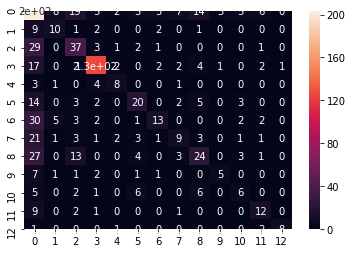

In [35]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

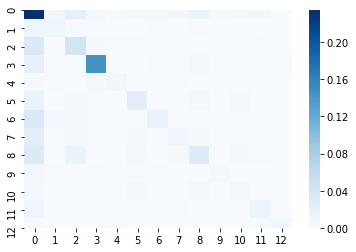

In [36]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), fmt='.2%', cmap='Blues')

In [37]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(true_vals, y_pred)

for label, i in label_dict.items():
    print('{}: \t\tprecision: {:.2f}, recall: {:.2f}, fscore: {:.2f}, support: {}'.format(label, precision[i], recall[i], fscore[i], support[i]))

Solution Discussion: 		precision: 0.54, recall: 0.72, fscore: 0.62, support: 282
Expected Behaviour: 		precision: 0.38, recall: 0.40, fscore: 0.39, support: 25
Usage: 		precision: 0.43, recall: 0.50, fscore: 0.46, support: 74
Social Conversation: 		precision: 0.85, recall: 0.79, fscore: 0.82, support: 159
Contribution and Commitment: 		precision: 0.50, recall: 0.47, fscore: 0.48, support: 17
Bug Reproduction: 		precision: 0.48, recall: 0.41, fscore: 0.44, support: 49
Motivation: 		precision: 0.52, recall: 0.22, fscore: 0.31, support: 58
Potential New Issues and Requests: 		precision: 0.36, recall: 0.20, fscore: 0.25, support: 46
Investigation and Exploration: 		precision: 0.42, recall: 0.32, fscore: 0.36, support: 75
Workarounds: 		precision: 0.56, recall: 0.28, fscore: 0.37, support: 18
Observed Bug Behaviour: 		precision: 0.30, recall: 0.23, fscore: 0.26, support: 26
Task Progress: 		precision: 0.44, recall: 0.48, fscore: 0.46, support: 25
Action on Issue: 		precision: 0.89, recall: 

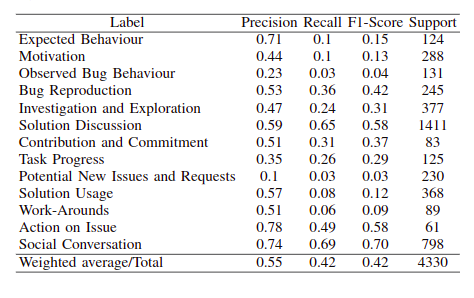

In [28]:
label_dict.keys()

dict_keys(['Solution Discussion', 'Expected Behaviour', 'Usage', 'Social Conversation', 'Contribution and Commitment', 'Bug Reproduction', 'Motivation', 'Potential New Issues and Requests', 'Investigation and Exploration', 'Workarounds', 'Observed Bug Behaviour', 'Task Progress', 'Action on Issue'])